# Documentation for the creation and usage of the heat pump library (hplib)

1. [Definitions](#definitions)
2. [Database preperation](#database-preparation)
3. [Work with database](#work-with-database)
    1. [Load database](#load-database)
    2. [Load specific model](#load-specific-model)
    3. [Load generic model](#load-generic-model)
4. [How to simulate](#how-to-simulate)
    1. [Simulate on time step](#simulate-one-timestep)
    2. [Simulate a time series](#simulate-a-timeseries)
5. [Example heat pump](#example-heat-pump)
6. [Validation](#validation)
    1. [Air/Water | on/off](#air-water-onoff)
    2. [Brine/Water | on/off](#brine-water-onoff)
    3. [Water/Water | on/off](#water-water-onoff)
    4. [Air/Water | regulated](#air-water-regulated)
    5. [Brine/Water | regulated](#brine-water-regulated)
7. [Conclusion](#conclusion)

In [2]:
import hplib as hpl
import hplib_database as db
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [35]:
%%html
<style>
table {float:left}
</style>

## **1. Definitions** <a class="anchor" id="definitions" name="definitions"></a>

**Abbreviations**

| Abbreviation | Meaning |
| :--- | :--- |
| P_th | Thermal output power in W |
| P_el | Electical input Power in W |
| COP | Coefficient of performance |
| T_in | Input temperature in °C at primary side of the heat pump |
| T_out | Output temperature in °C at secondary side of the heat pump |
| T_amb | Ambient temperature in °C |
| P_th_ref | Thermal output power in W at T_in = -7 °C and T_out = 52 °C |
| P_el_ref | Elecrical output power in W at T_in = -7 °C and T_out = 52 °C |
| COP_ref | Coefficient of performance at T_in = -7 °C and T_out = 52 °C |
| p1-p4 | Fit-Parameters for Fit-Function |



**Group IDs**

| Group ID | Type | Subtype |
| :--- | :--- | :--- |
| 1 | Outdoor Air / Water | Regulated | 
| 2 | Brine / Water | Regulated | 
| 3 | Water / Water | Regulated | 
| 4 | Outdoor Air / Water | On-Off | 
| 5 | Brine / Water | On-Off | 
| 6 | Water / Water | On-Off |

## **2. Database preparation** <a class="anchor" id="database-preparation" name="database-preparation"></a>

This section is only for documentation regarding the development of the final database. It's not neccesary to run this code again.

1. we downloaded all manufacturer data from https://keymark.eu/en/products/heatpumps/certified-products .
2. then we unzipped the files to the `input` folder and used the bash-skript `pdf2txt.sh` to convert pdf into txt.
3. afterwards we used the following functions to create and extent the heatpump keymark database.

In [17]:
# Import keymark data and save to csv database
db.import_keymark_data()
# -> this creates /output/database_keymark.csv

In [ ]:
# Reduce to climate measurement series with average climate, delete redundant entries and save to csv sub-database
db.reduce_keymark_data('database_keymark.csv','average')
# -> this creates /output/database_keymark_average.csv

In [ ]:
# Normalize electrical and thermal power from the keymark database to values from setpoint T_in = -7 °C and T_out = 52 °C
db.normalize_keymark_data('database_keymark_average.csv')
# -> this creates /output/database_keymark_average_normalized.csv

In [ ]:
# Identify subtypes like on-off or regulated heat pumps and assign group id depending on its type and subtype
db.identify_subtypes('database_keymark_average_normalized.csv')
# -> this creates /output/database_keymark_average_normalized_subtypes.csv

In [ ]:
# Calculate parameters p1-p4 for P_th, P_el and COP with a least-square fit approach
# based on  K. Schwamberger: „Modellbildung und Regelung von Gebäudeheizungsanlagen 
# mit Wärmepumpen“, VDI Verlag, Düsseldorf, Fortschrittsberichte VDI Reihe 6 Nr. 263, 1991.
db.calculate_function_parameters('database_keymark_average_normalized_subtypes.csv')
# -> this creates the final hplib_database.csv

In [ ]:
# Many heat pump models have redundant entries because of different controller or storage configurations.
# Reduce to unique heat pump models.
db.reduce_to_unique()
# -> this overwrites the hplib_database.csv

In [ ]:
# Calculate the relative error (RE) for each set point of every heat pump
db.validation_relative_error()
# -> this creates /output/database_keymark_average_normalized_subtypes_validation.csv

In [ ]:
# Calculate the mean absolute percentage error (MAPE) for every heat pump
db.validation_mape()
# -> this overwrites the hplib_database.csv

In [ ]:
# Calculate generic heat pump models for each group id
db.add_generic()
# -> this overwrites the hplib_database.csv

**Hint:** The csv files in the `output` folder are for documentation and validation purpose. The code `hplib.py` and database `hplib_database` files, which are meant to be used for simulations, are located in the `src` folder. 

## **3. Work with database** <a class="anchor" id="work-with-database" name="work-with-database"></a>

### **3.1 Load database**  <a class="anchor" id="load-database" name="load-database"></a>

Simply execute the command without arguments and you will get a DataFrame with the complete list of manufacturers and models. Now you are able to view, filter or sort the database.

In [3]:
database = hpl.load_database()
database

,Manufacturer,Model,Date,Type,Subtype,Group,Refrigerant,Mass of Refrigerant [kg],SPL indoor [dBA],SPL outdoor [dBA],...,p2_P_el [1/°C],p3_P_el [-],p4_P_el [1/°C],p1_COP [-],p2_COP [-],p3_COP [-],p4_COP [-],MAPE_P_el,MAPE_COP,MAPE_P_th
0,Advantix,i-SHWAK V4 06,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,2.68,35.0,64.0,...,0.012686,-0.051998,-255.216376,-40.360701,-0.042594,4.862192,40.502338,22.607658,9.244852,24.897666
1,Advantix,i-SHWAK V4 08,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,2.20,35.0,64.0,...,0.012931,-0.043319,-158.414765,221.722238,-0.039243,4.806831,-221.576626,21.795155,7.122293,23.693852
2,Advantix,i-SHWAK V4 10,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,3.45,39.0,64.0,...,0.011790,0.024668,-292.209051,212.852441,-0.073052,6.208805,-212.682484,22.456618,8.341953,25.851260
3,Advantix,i-SHWAK V4 12,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,3.45,39.0,65.0,...,0.008599,0.202072,74.352921,318.330520,-0.077418,6.435352,-318.207408,18.080641,8.020945,23.069767
4,Advantix,i-SHWAK V4 14,2020-05-26,Outdoor Air/Water,Regulated,1.0,R410a,4.40,40.0,68.0,...,0.010612,0.062583,71.508022,208.402883,-0.059670,5.518714,-208.245752,12.936314,13.701883,15.020363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,Generic,Generic,NaN,Brine/Water,Regulated,2.0,NaN,NaN,NaN,NaN,...,0.013036,0.069821,-0.034154,0.098565,-0.098565,8.122413,-0.000109,NaN,NaN,NaN
507,Generic,Generic,NaN,Water/Water,Regulated,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508,Generic,Generic,NaN,Outdoor Air/Water,On-Off,4.0,NaN,NaN,NaN,NaN,...,0.012577,0.362294,-52.806429,60.048530,-0.060318,5.696027,-59.953197,NaN,NaN,NaN
509,Generic,Generic,NaN,Brine/Water,On-Off,5.0,NaN,NaN,NaN,NaN,...,0.015276,0.241917,0.004298,0.103930,-0.103930,8.054636,-0.031898,NaN,NaN,NaN


### **3.2 Load specific model**  <a class="anchor" id="load-specific-model" name="load-specific-model"></a>

To get the parameters of a specific heat pump model, use the `get_parameters()` method with a specific Model name from the database.
You will get a DataFrame with all parameters including the mean absolute percentage errors (MAPE) for this model.

In [4]:
parameters = hpl.get_parameters('i-SHWAK V4 06')
parameters

,Manufacturer,Model,MAPE_COP,MAPE_P_el,MAPE_P_th,P_th_ref [W],P_el_ref [W],COP_ref,Group,p1_P_th [1/°C],...,p3_P_th [-],p4_P_th [1/°C],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p4_P_el [1/°C],p1_COP [-],p2_COP [-],p3_COP [-],p4_COP [-]
0,Advantix,i-SHWAK V4 06,9.244852,22.607658,24.897666,4500.0,2866.0,1.57,1.0,1.756924,...,1.284505,-1.780462,255.166152,0.012686,-0.051998,-255.216376,-40.360701,-0.042594,4.862192,40.502338


### **3.3 Load generic model**  <a class="anchor" id="load-generic-model" name="load-generic-model"></a>

To get the parameters of a generic heat pump model, use the `get_parameters()` method with the following keyword arguments of a free choosen set point

* model='Generic'
* group_id: 1,2,4,5,6
* t_in: choose primary input temperature in °C
* t_out: choose secondary output temperature in °C
* p_th: choose thermal output power in W

You will get a DataFrame with all parameters for this generic model. For every group id the parameter set is based on the average parameters of all heat pumps of its group with an MAPE of less than 25%.

In [2]:
parameters = hpl.get_parameters(model='Generic', group_id=1, t_in=-7, t_out=52, p_th=10000)
parameters

,Manufacturer,Model,MAPE_COP,MAPE_P_el,MAPE_P_th,P_th_ref [W],P_el_ref [W],COP_ref,Group,p1_P_th [1/°C],...,p3_P_th [-],p4_P_th [1/°C],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p4_P_el [1/°C],p1_COP [-],p2_COP [-],p3_COP [-],p4_COP [-]
0,Generic,Generic,NaN,NaN,NaN,10168.784585,7193.412457,1.413625,1.0,60.824594,...,0.9135,-60.852801,72.146637,0.011365,0.047007,-72.195983,47.568472,-0.087569,7.0455,-47.414428


## **4. How to simulate** <a class="anchor" id="how-to-simulate" name="how-to-simulate"></a>

With the Fit-Parameters p1-p4 for P_th, P_el and COP it is possible to calculate the results with the following methods:

1. P_th and P_el with Fit-Functions and `COP = P_th / P_el` or
2. P_th and COP with Fit-Functions and `P_el = P_th / COP` or
3. P_el and COP with Fut-Functions and `P_th = P_el * COP`

While the model by Schwarmberger [1] uses the first method, our validation showed, that the third method leads to better results. Therefore we decided to implement this in the `simulate` definition.

### **4.1 Simulate one timestep**  <a class="anchor" id="simulate-one-timestep" name="simulate-one-timestep"></a>

Please define a primary input temperature (t_in_primary), secondary input temperature (t_in_secondary),
ambient / outdoor temperature (t_amb) in °C and the parameters from the previous step. The t_in_secondary
is supposed to be heated up by 5 K which then results in output temperature.

Important:
* for air / water heat pumps t_in_primary and t_amb are supposed to be the same values.
* for brine / water or water / water heat pumps t_in_primary and t_amb are independent values.

In [6]:
results = hpl.simulate(t_in_primary=-7, t_in_secondary=47, parameters=parameters, t_amb=-7)
results

,T_in,T_out,T_amb,COP,P_el,P_th,m_dot
0,-7,52,-7,1.41,7074.0,10000.0,0.476


### **4.2 Simulate a timeseries**  <a class="anchor" id="simulate-a-timeseries" name="simulate-a-timeseries"></a>

The simulation approach is the same as for one timestep. For a timeseries your are allowed
to define pandas.Series or arrays as input values. It is also possible to combine single values 
and pandas.Series / arrays.

*The next example uses a measured timeseries for ambient / outdoor temperature and secondary 
input temperature of a real heating system to demonstrate the simulation approach. The data represents
on year and has a temporal resolution of 1 minute*

SPF = 3.9


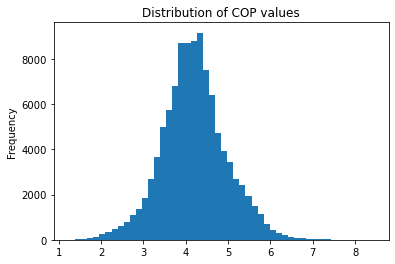

In [5]:
df = pd.read_csv('../input/TestYear.csv')
df['T_amb'] = df['T_in_primary'] # air/water heat pump -> T_amb = T_in_primary
results = hpl.simulate(t_in_primary=df['T_in_primary'], t_in_secondary=df['T_in_secondary'], parameters=parameters, t_amb=df['T_amb'])
# Plot / Print some results
# example for distribution of COPs
results['COP'].plot.hist(bins=50, title='Distribution of COP values') 
# Calclulate seasonal performance factor (SPF)
SPF = results['P_th'].mean() / results['P_el'].mean() 
print('SPF = '+str(round(SPF,1)))

## **5. Example heat pump** <a class="anchor" id="example-heat-pump" name="example-heat-pump"></a>

**Schematic plot** of COP, P_el and P_th for an **generic air/water** heat pump: subtype = **On-Off** 

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

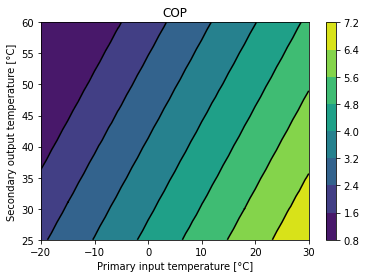

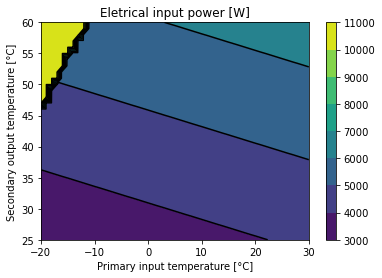

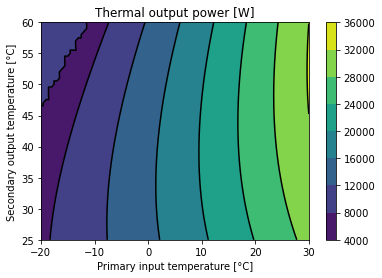

In [15]:
# Define Temperatures
T_in_primary = range(-20,31)
T_in_secondary = range(20,56)
T_in = []
T_out = []

# Load parameters of generic air/water | on-off
p = hpl.get_parameters('Generic', group_id=4, t_in=-7, t_out=52, p_th = 10000)

# Create input series
for t1 in T_in_primary:
    for t2 in T_in_secondary:
        T_in.append(t1)
        T_out.append(t2)
df=pd.DataFrame()
df['T_in']=T_in
df['T_out']=T_out

# Simulation
results = hpl.simulate(t_in_primary=df['T_in'], t_in_secondary=df['T_out'], parameters=p, t_amb=df['T_in'])

# Plot COP
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['COP'])
ax1.tricontour(results['T_in'], results['T_out'], results['COP'], colors='k')
fig1.colorbar(plot)
ax1.set_title('COP')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot electrical input power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_el'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_el'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Eletrical input power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot thermal output power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in'], results['T_out'], results['P_th'])
ax1.tricontour(results['T_in'], results['T_out'], results['P_th'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Thermal output power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

**COP**:
* The COP goes up with higher primary input values. 
* The COP goes up with lower secondary output values.

**P_el**:
* The electrical input power is relativey constant for an on/off heatpump.
* At low primary input and high secondary output temperatures the COP would fall below 1. In this case the a electric heating rod is assumed and the electrical power is set to the thermal power at set point -7/52 °C.

**P_th**:
* For this on/off air/water heat pump, the thermal power is mainly dependend von the primary input temperature. 

## **6. Validation** <a class="anchor" id="validation" name="validation"></a>

The following plots will give you a detailed view on the differences between simulation and measurement from heat pump keymark. Therefore, all set points for all heat pumps are loaded from the file `database_keymark_average_normalized_subtypes_validation.csv`.

In [3]:
df = pd.read_csv('../output/database_keymark_average_normalized_subtypes_validation.csv')

### **6.1 Air/Water | on/off** <a class="anchor" id="air-water-onoff" name="air-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 5.4 % for COP
    * 2.5 % for P_el
    * 5.8 % for P_th
* The errors come from deviation mostly at low ambient / outside temperatures

RE_COP     5.404139
RE_P_el    2.525073
RE_P_th    5.806641
dtype: float64

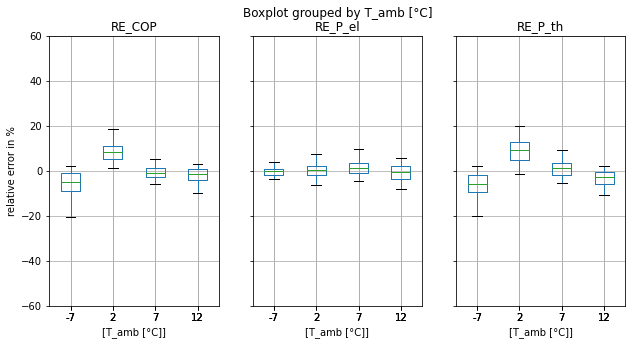

In [21]:
# Plot relative error for all heat pumps of type air/water | on-off
Group = 4
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

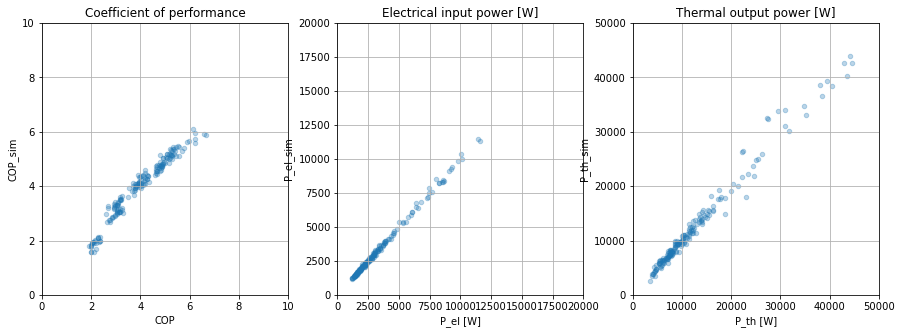

In [22]:
# Plot absolute values all heat pumps of type air/water | on-off as scatter plot
Group = 4
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.2 Brine/Water | on/off** <a class="anchor" id="brine-water-onoff" name="brine-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 3.9 % for COP
    * 1.7 % for P_el
    * 2.7 % for P_th
* **Important**: Validation data is only available at primary input temperature of 0 °C.  

RE_COP     3.897897
RE_P_el    1.678427
RE_P_th    2.668440
dtype: float64

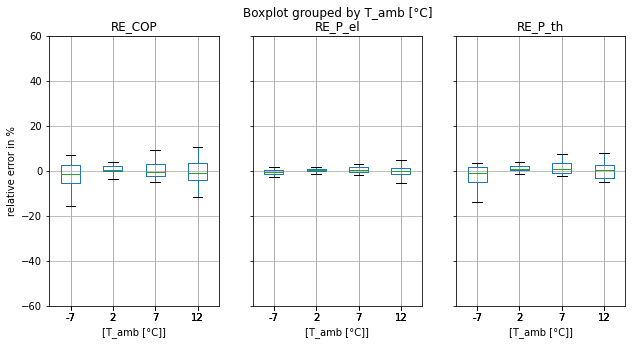

In [23]:
# Plot relative error for all heat pumps of type brine/water | on-off
Group = 5
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

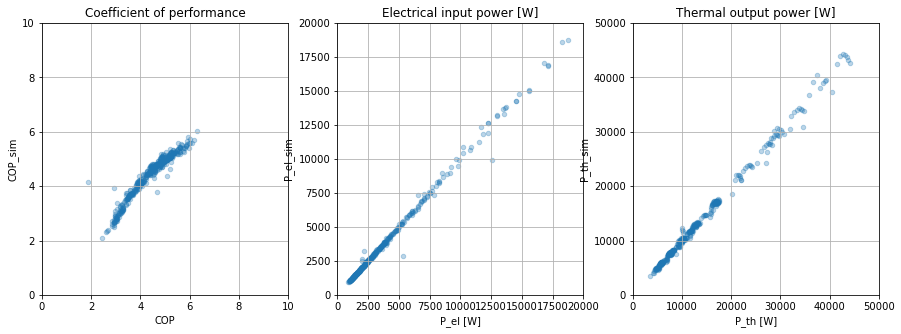

In [24]:
# Plot absolute values all heat pumps of type brine/water | on-off as scatter plot
Group = 5
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.3 Water/Water | on/off** <a class="anchor" id="water-water-onoff" name="water-water-onoff"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 1.6 % for COP
    * 1.6 % for P_el
    * 2.4 % for P_th
* **Important**: Validation data is only available at primary input temperature of 10 °C.

RE_COP     1.563460
RE_P_el    1.582038
RE_P_th    2.415430
dtype: float64

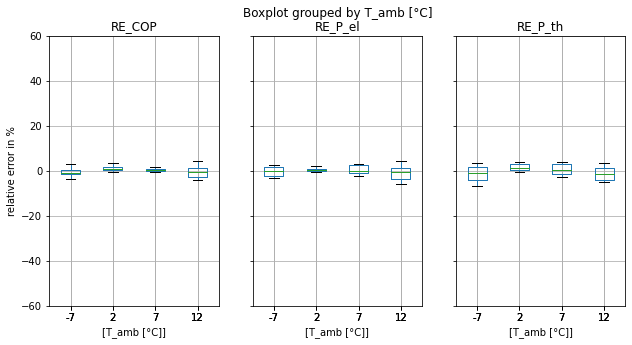

In [25]:
# Plot relative error for all heat pumps of type water/water | on-off
Group = 6
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

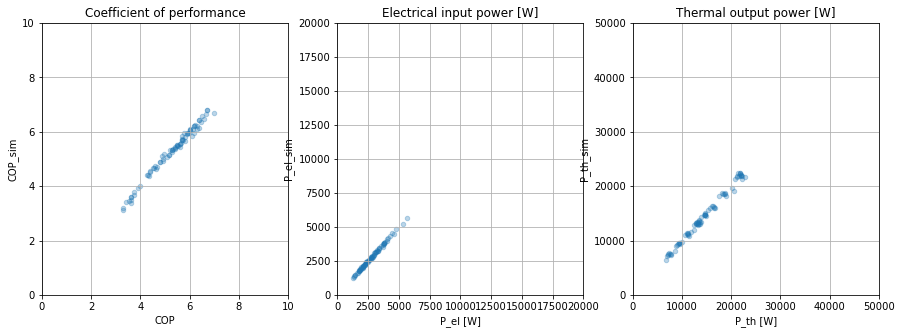

In [26]:
# Plot absolute values all heat pumps of type water/water | on-off as scatter plot
Group = 6
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.3, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.3, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.4 Air/Water | regulated** <a class="anchor" id="air-water-regulated" name="air-water-regulated"></a>

* The mean absolute percentage error (MAPE) over all heat pumps is
    * 12.1 % for COP
    * 19.5 % for P_el
    * 23.5 % for P_th
* Because of different control strategies, the deviation over different heat pump models is much higher compared to on/off types. 

RE_COP     12.076421
RE_P_el    19.456381
RE_P_th    23.522196
dtype: float64

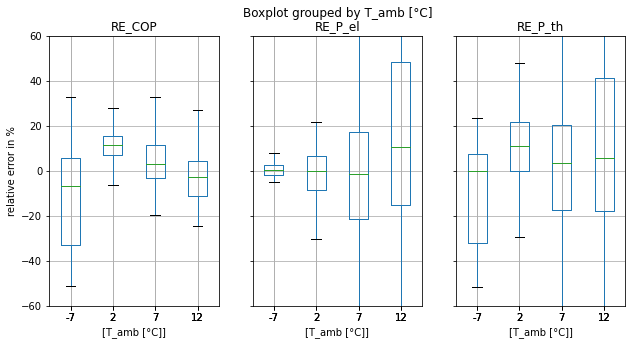

In [27]:
# Plot relative error for all heat pumps of type air/water | regulated
Group = 1
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

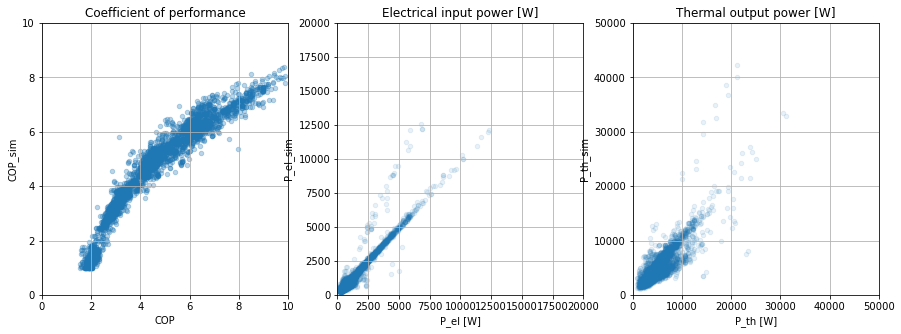

In [28]:
# Plot absolute values all heat pumps of type air/water | regulated as scatter plot
Group = 1
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

### **6.5 Brine/Water | regulated** <a class="anchor" id="brine-water-regulated" name="brine-water-regulated"></a>

* The mean absolute percentage error (MAPE) is over all heat pumps is
    * 4.2 % for COP
    * 17.7 % for P_el
    * 19.7 % for P_th
* **Important**: Validation data is only available at primary input temperature of 0 °C.  
* The errors come from deviation mostly at high ambient / outside temperatures.
* Error of COP is very low compared to error of P_el.

RE_COP      4.228648
RE_P_el    17.650300
RE_P_th    19.737515
dtype: float64

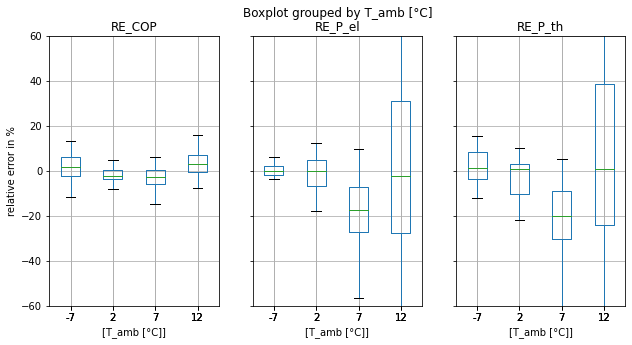

In [31]:
# Plot relative error for all heat pumps of type brine/water | regulated
Group = 2
data = df.loc[(df['Group']==Group)]
data = data[['T_amb [°C]','RE_COP', 'RE_P_el', 'RE_P_th']]
ax = data.boxplot(by='T_amb [°C]', layout=(1,3), figsize=(10,5), showfliers=False)
ax[0].set_ylim(-60,60)
ax[0].set_ylabel('relative error in %')
data.abs().mean()[1:4] # mean absolute percentage error (MAPE)

(0.0, 50000.0)

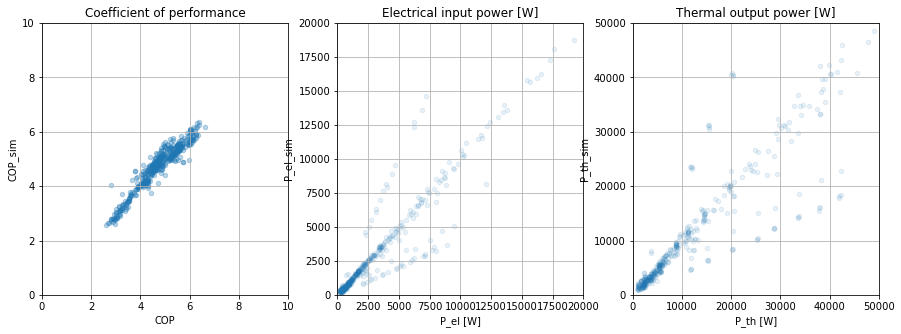

In [32]:
# Plot absolute values all heat pumps of type brine/water | regulated as scatter plot
Group = 2
fig, ax = plt.subplots(1,3)
data = df.loc[(df['Group']==Group)]
data.plot.scatter(ax=ax[0], x='COP',y='COP_sim', alpha=0.3, figsize=(12,5), grid=True, title='Coefficient of performance')
data.plot.scatter(ax=ax[1], x='P_el [W]',y='P_el_sim', alpha=0.1, figsize=(15,5), grid=True, title='Electrical input power [W]')
data.plot.scatter(ax=ax[2], x='P_th [W]',y='P_th_sim', alpha=0.1, figsize=(15,5), grid=True, title='Thermal output power [W]')
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)
ax[1].set_xlim(0,20000)
ax[1].set_ylim(0,20000)
ax[2].set_xlim(0,50000)
ax[2].set_ylim(0,50000)

## **7. Conclusion** <a class="anchor" id="conclusion" name="conclusion"></a>

- On/Off heat pumps can be simulated very well (mean relative error < 6 %)
- Regulated heat pumps show relative mean errors about 20 %, because of the non-linearity of electrical input power and COP regarding different primary / secondary temperatures
- Despite of that, generic heat pumps should work well, because the median shows only a small relative error